In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
%pip install -U py_distance_transforms
from py_distance_transforms import transform, transform_cuda
%pip install -U tensorflow-addons
%pip install -U FastGeodis
%pip install -U opencv-python

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import torch
import tensorflow as tf
import tensorflow_addons as tfa
from scipy.ndimage import distance_transform_edt
import FastGeodis
import cv2

In [59]:
def numpy_to_tf_binary_array(array):
    with tf.device('/GPU:0'):
        binary_array = tf.cast(array, tf.float32)
        gray_array = tf.image.convert_image_dtype(binary_array, tf.uint8)
        return gray_array

## 2D

In [102]:
# Configure the range of sizes for 2D and 3D
range_size_2D = [2**i for i in range(3, 13)]
range_size_3D = [2**i for i in range(0, 9)]

In [103]:
# Initialize arrays to store the results
sizes = []
dt_scipy = []
dt_pydt_single = []
dt_pydt_multi = []
dt_pydt_cuda = []
dt_tfa = []
dt_fastgeodis = []
dt_opencv = []

# 2D benchmarks
for n in range_size_2D:
    print(f"Running benchmark for size: {n}")
    sizes.append(n**2)
    f = np.random.randint(0, 2, size=(n, n)).astype(np.float32)
    f_pt = torch.from_numpy(f).to('cuda')
    f_tf = numpy_to_tf_binary_array(f)

    # SciPy distance_transform_edt
    t_scipy = timeit.timeit(lambda: distance_transform_edt(f), number=10)
    dt_scipy.append(t_scipy * 1e9 / 10)  # Convert to nanoseconds

    # py_distance_transforms CPU single-threaded
    t_pydt_single = timeit.timeit(lambda: transform(f), number=10)
    dt_pydt_single.append(t_pydt_single * 1e9 / 10)  # Convert to nanoseconds

    # py_distance_transforms CPU multi-threaded
    t_pydt_multi = timeit.timeit(lambda: transform(f), number=10)
    dt_pydt_multi.append(t_pydt_multi * 1e9 / 10)  # Convert to nanoseconds

    # py_distance_transforms CUDA
    t_pydt_cuda = timeit.timeit(lambda: transform_cuda(f_pt), number=10)
    dt_pydt_cuda.append(t_pydt_cuda * 1e9 / 10)  # Convert to nanoseconds

    # TensorFlow Addons distance transform
    t_tfa = timeit.timeit(lambda: tfa.image.euclidean_dist_transform(tf.expand_dims(f_tf, 0)), number=10)
    dt_tfa.append(t_tfa * 1e9 / 10)  # Convert to nanoseconds

    # FastGeodis Euclidean distance transform
    f_pt_unsqueezed = f_pt.unsqueeze_(0).unsqueeze_(0)
    t_fastgeodis = timeit.timeit(lambda: FastGeodis.generalised_geodesic2d(f_pt_unsqueezed, torch.ones_like(f_pt_unsqueezed), 1e10, 0.0, 2), number=10)
    dt_fastgeodis.append(t_fastgeodis * 1e9 / 10)  # Convert to nanoseconds

    # OpenCV distance transform
    t_opencv = timeit.timeit(lambda: cv2.distanceTransform((f * 255).astype(np.uint8), cv2.DIST_L2, 5), number=10)
    dt_opencv.append(t_opencv * 1e9 / 10)  # Convert to nanoseconds

Running benchmark for size: 8
Running benchmark for size: 16
Running benchmark for size: 32
Running benchmark for size: 64
Running benchmark for size: 128
Running benchmark for size: 256
Running benchmark for size: 512
Running benchmark for size: 1024
Running benchmark for size: 2048
Running benchmark for size: 4096


In [104]:
# Initialize arrays to store the results for 3D
sizes_3D = []
dt_scipy_3D = []
dt_pydt_single_3D = []
dt_pydt_multi_3D = []
dt_pydt_cuda_3D = []
dt_tfa_3D = []
dt_fastgeodis_3D = []

# 3D benchmarks
for n in range_size_3D:
    print(f"Running benchmark for size: {n}")
    sizes_3D.append(n**3)
    f = np.random.randint(0, 2, size=(n, n, n)).astype(np.float32)
    f_pt = torch.from_numpy(f).to('cuda')
    f_tf = numpy_to_tf_binary_array(f)

    # SciPy distance_transform_edt
    t_scipy_3D = timeit.timeit(lambda: distance_transform_edt(f), number=10)
    dt_scipy_3D.append(t_scipy_3D * 1e9 / 10)  # Convert to nanoseconds

    # py_distance_transforms CPU single-threaded
    t_pydt_single_3D = timeit.timeit(lambda: transform(f), number=10)
    dt_pydt_single_3D.append(t_pydt_single_3D * 1e9 / 10)  # Convert to nanoseconds

    # py_distance_transforms CPU multi-threaded
    t_pydt_multi_3D = timeit.timeit(lambda: transform(f), number=10)
    dt_pydt_multi_3D.append(t_pydt_multi_3D * 1e9 / 10)  # Convert to nanoseconds

    # py_distance_transforms CUDA
    t_pydt_cuda_3D = timeit.timeit(lambda: transform_cuda(f_pt), number=10)
    dt_pydt_cuda_3D.append(t_pydt_cuda_3D * 1e9 / 10)  # Convert to nanoseconds

    # TensorFlow Addons distance transform
    t_tfa_3D = timeit.timeit(lambda: tfa.image.euclidean_dist_transform(tf.expand_dims(f_tf, 0)), number=10)
    dt_tfa_3D.append(t_tfa_3D * 1e9 / 10)  # Convert to nanoseconds

    # FastGeodis Euclidean distance transform
    f_pt_unsqueezed = f_pt.unsqueeze_(0).unsqueeze_(0)
    t_fastgeodis_3D = timeit.timeit(lambda: FastGeodis.generalised_geodesic3d(f_pt_unsqueezed, torch.ones_like(f_pt_unsqueezed), [1.0, 1.0, 1.0], 1e10, 0.0, 2), number=10)
    dt_fastgeodis_3D.append(t_fastgeodis_3D * 1e9 / 10)  # Convert to nanoseconds


Running benchmark for size: 1
Running benchmark for size: 2
Running benchmark for size: 4
Running benchmark for size: 8
Running benchmark for size: 16
Running benchmark for size: 32
Running benchmark for size: 64
Running benchmark for size: 128
Running benchmark for size: 256


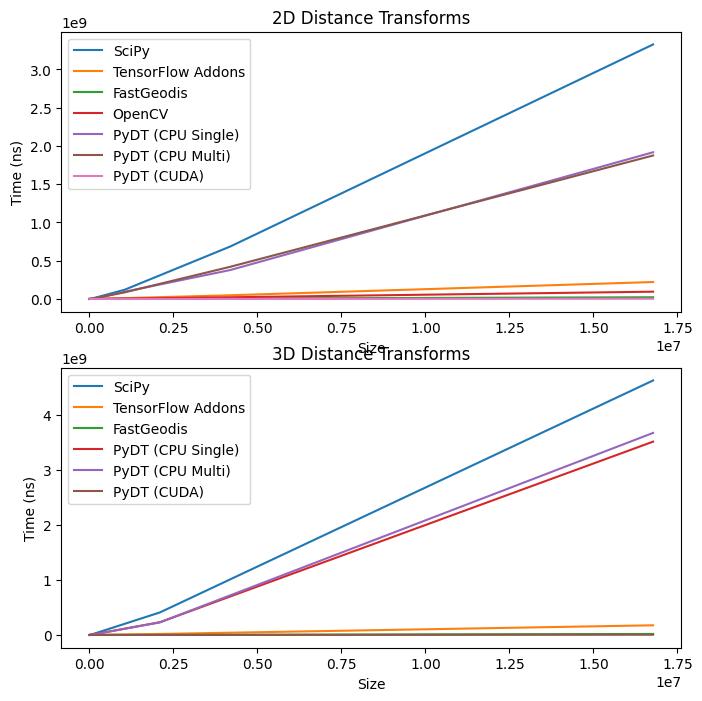

In [109]:
# Create a matplotlib plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

ax1.plot(sizes, dt_scipy, label='SciPy')
ax1.plot(sizes, dt_tfa, label='TensorFlow Addons')
ax1.plot(sizes, dt_fastgeodis, label='FastGeodis')
ax1.plot(sizes, dt_opencv, label='OpenCV')
ax1.plot(sizes, dt_pydt_single, label='PyDT (CPU Single)')
ax1.plot(sizes, dt_pydt_multi, label='PyDT (CPU Multi)')
ax1.plot(sizes, dt_pydt_cuda, label='PyDT (CUDA)')
ax1.set_xlabel('Size')
ax1.set_ylabel('Time (ns)')
ax1.set_title('2D Distance Transforms')
ax1.legend()

ax2.plot(sizes_3D, dt_scipy_3D, label='SciPy')
ax2.plot(sizes_3D, dt_tfa_3D, label='TensorFlow Addons')
ax2.plot(sizes_3D, dt_fastgeodis_3D, label='FastGeodis')
ax2.plot(sizes_3D, dt_pydt_single_3D, label='PyDT (CPU Single)')
ax2.plot(sizes_3D, dt_pydt_multi_3D, label='PyDT (CPU Multi)')
ax2.plot(sizes_3D, dt_pydt_cuda_3D, label='PyDT (CUDA)')
ax2.set_xlabel('Size')
ax2.set_ylabel('Time (ns)')
ax2.set_title('3D Distance Transforms')
ax2.legend()

In [110]:
df_dt_2d = pd.DataFrame({
    'sizes': sizes,
    'dt_scipy': dt_scipy,
    'dt_tfa': dt_tfa,
    'dt_fastgeodis': dt_fastgeodis,
    'dt_opencv': dt_opencv,
    'dt_pydt_single': dt_pydt_single,
    'dt_pydt_multi': dt_pydt_multi,
    'dt_pydt_cuda': dt_pydt_cuda,
})

In [111]:
df_dt_3d = pd.DataFrame({
    'sizes_3D': sizes_3D,
    'dt_scipy_3D': dt_scipy_3D,
    'dt_tfa_3D': dt_tfa_3D,
    'dt_fastgeodis_3D': dt_fastgeodis_3D,
    'dt_pydt_single_3D': dt_pydt_single_3D,
    'dt_pydt_multi_3D': dt_pydt_multi_3D,
    'dt_pydt_cuda_3D': dt_pydt_cuda_3D
})

In [112]:
# Save the DataFrame to a CSV file
if torch.cuda.is_available():
    accelerator = 'CUDA'
else:
    accelerator = 'CPU'

csv_filename_2d = f"/content/drive/MyDrive/dev/MolloiLab/distance-transforms-paper/data/dt_py_2D_{accelerator}.csv"
csv_filename_3d = f"/content/drive/MyDrive/dev/MolloiLab/distance-transforms-paper/data/dt_py_3D_{accelerator}.csv"

df_dt_2d.to_csv(csv_filename_2d, index=False)
df_dt_3d.to_csv(csv_filename_3d, index=False)